## Train CNN based on Udacity

This notebook is to debug the outline training the CNN, specifically to ensure that the training data is as expected and the output from a training or testing run can be visualised.

Note that in order to train the CNN, this code will need to be run on GCP (or similar GPU-based server).


### Setup environments

#### Imports

Note that these imports are for the purposes of this notebook, they will be different when running `train.py` or `test.py`

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import Callback, TensorBoard, EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from nn import nn
from nn import data_reader
from tracklets import generate_tracklet


#### Set up environment variables (Mac)

Run this section for training/testing on my Mac

In [4]:
BATCH_SIZE = 1
DATA_DIR = '/vol/didi/dataset2/Tracklets/1/2/'
LOGDIR = '/vol/training/logs'
TRAIN_DIR = '/vol/dataset2/Train/'
PREDICT_DIR = '/vol/dataset2/Predict/'
CSV='data.csv'
CHECKPOINT_EVERY = 100
NUM_STEPS = int(1e2)   # Run for 100 steps
CKPT_FILE = 'model.ckpt'
LEARNING_RATE = 1e-3
KEEP_PROB = 0.8
L2_REG = 0
EPSILON = 0.001
MOMENTUM = 0.9

#### Set up environment variables (GCP)

Run this for training/testing on GCP instance

In [ ]:
BATCH_SIZE = 1
DATA_DIR = '/vol/dataset2/Didi-Release-2/Tracklets/1/2/'
LOGDIR = '/vol/training/logs'
TRAIN_DIR = '/vol/dataset2/Didi-Release-2/Train/'
PREDICT_DIR = '/vol/dataset2/Didi-Release-2/Predict/'
CSV='data.csv'
CHECKPOINT_EVERY = 100
NUM_STEPS = int(1e2)   # Run for 100 steps
CKPT_FILE = 'model.ckpt'
LEARNING_RATE = 1e-3
KEEP_PROB = 0.8
L2_REG = 0
EPSILON = 0.001
MOMENTUM = 0.9

### Setup model

This currently assumes u-net based model configured in nn/nn.py

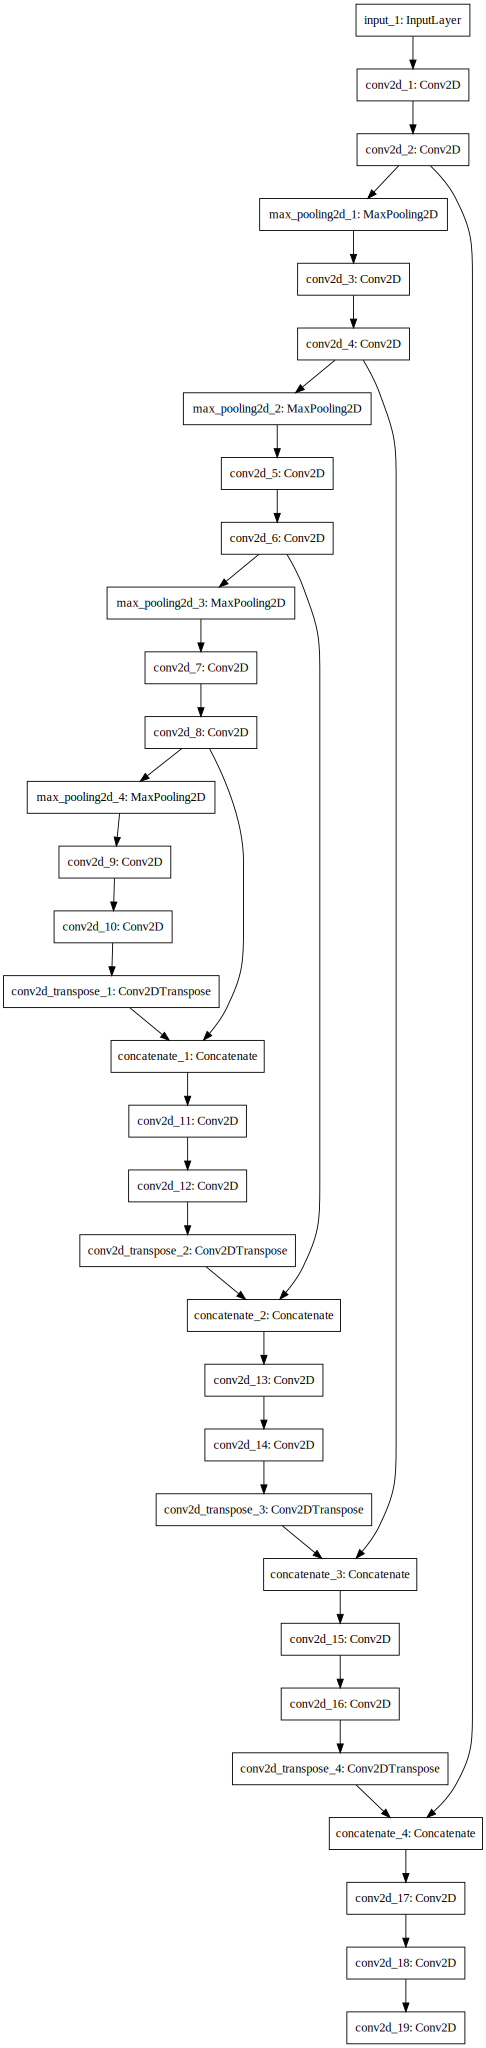

In [5]:
LossHistory, model = nn.top_nn()
# summary = model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Setup data_reader() for loading data

In [6]:
data_reader = data_reader.DataReader(DATA_DIR)

Parsing Tracklet file /vol/didi/dataset2/Tracklets/1/2/tracklet_labels.xml
File contains 1 Tracklets
Loaded 1 Tracklets


Load a single training sample to get things moving

In [7]:
xs, ys = data_reader.load_train_batch(batch_size=BATCH_SIZE)

Display info about the training data:

* xs = `pointcloud.npy` data based on the format created by `sensor_pipeline/extract_pointclouds.py`
* ys = mask of obstacle in (0,1) format, where 0=background and 1=obstacle (car)

In [8]:
print ('xs.shape={}'.format(xs.shape))
print ('ys.shape={}'.format(ys.shape))

xs.shape=(1, 400, 400, 8)
ys.shape=(1, 400, 400, 1)


Render the training mask and the respective point cloud image (generated by `pointcloud_utils/create_pointcloud_image.py`)

In [9]:
mask=ys[0,:,:,0]
timestamp=''
pointcloud_image_file=os.path.join(DATA_DIR, 'processed', 'lidar_top_img', '1490991281474291000.png')

In [10]:
print (mask)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


(400, 400)


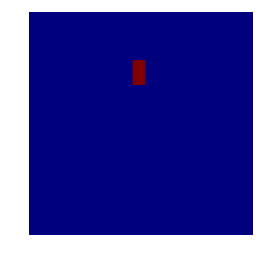

In [11]:
print (mask.shape)

plt.axis("off")
plt.imshow(mask)
plt.show()